In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns 
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# Loading Data Set


In [4]:
#---------------Loading Train Data------------------#
data_train= pd.read_csv("a3-train.data",delimiter=" ",header= None)
data_label = pd.read_csv("a3-train.labels.txt",delimiter=" ",header = None)
data_train.iloc[:,500] = data_label.iloc[:,0].copy()
Xtrain = data_train.iloc[:,:500]
ytrain = data_train.iloc[:,500]


#--------------Loading Test data---------------------#
data_test = pd.read_csv("a3-test.data",delimiter=" ",header = None)
datatest_label = pd.read_csv("a3-test.labels.txt",delimiter=" ", header = None)
data_test.iloc[:,500] = datatest_label.iloc[:,0].copy()

Xtest = data_test.iloc[:,:500]
ytest = data_test.iloc[:,500]

# Exploratory Data Analysis

#### Checking for Missing Values:


In [5]:
print(data_train.isnull().values.any()) 

False


#### Checking for Duplicate rows or Duplicate columns

In [6]:
data_train = data_train.iloc[:,~data_train.columns.duplicated()]
data_train.shape

(2000, 501)

#### Checking for Unique Identifier Columns


In [7]:
count = 0
for i in data_train:
    temp = data_train.iloc[:,i].unique()
    if len(temp) == data_train.shape[0]:
        count+= 1
        print(i)
print(count)

0


#### Checking if the output column is balanced or not

In [8]:
print(data_train.shape)
data_train.iloc[:,500].value_counts()

(2000, 501)


 1    1000
-1    1000
Name: 500, dtype: int64

## Baseline Models for Logistic, Random Forests ,KNN, Gradient Boosting

#### Logistic Regression

In [9]:
# Logistic Regression 
logreg = LogisticRegression()
logreg.fit(Xtrain,ytrain)
logreg_base = logreg.score(Xtest,ytest)
print(logreg_base)


0.5916666666666667


#### Random Forest

In [10]:
# Random Forest(Without feature importance)
forest = RandomForestClassifier(random_state = 20)
forest.fit(Xtrain,ytrain)
randomforest_base = forest.score(Xtest,ytest)
temp = forest.feature_importances_
print(randomforest_base)

0.6283333333333333


#### KNN

In [11]:
# KNN     
knn = KNeighborsClassifier(n_neighbors= 1)
knn.fit(Xtrain,ytrain)
knn.score(Xtest,ytest)


0.6533333333333333

#### Gradient Boosting

In [12]:
# Gradient Boosting
Gradient_boosting = GradientBoostingClassifier()
Gradient_boosting.fit(Xtrain,ytrain)
gradientboosting_base = Gradient_boosting.score(Xtest,ytest)
print(gradientboosting_base)

0.7483333333333333


# Feature Engineering

#### Checking if any columns are corelated greater than 0.7 

In [13]:

corr_matrix = data_train.corr().abs() # creating corelating matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # selecting upper triangle of corr_matrix

#print(upper)

to_drop = [column for column in upper.columns if any(upper[column] >= 0.5)] # Find index of feature columns with correlation greater than 0.95

data_train.drop(data_train.columns[to_drop], axis=1)

data_train.shape


(2000, 501)

#### Pearson Corelation Matrix heat map (Takes time to run)

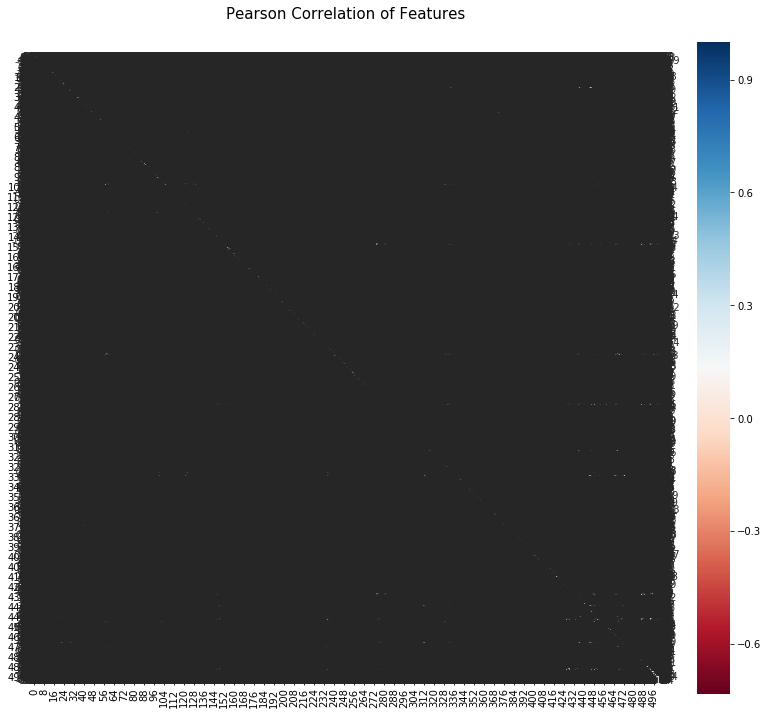

In [24]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Xtrain.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### Dropping unnessary features via Recursive Feature Elimination with Cross Validation

In [14]:
# Random Forest with Recursive Feature Elimination  with Cross Validation
forest = RandomForestClassifier(random_state = 20)

rfe_cv = RFECV(forest, step=1, cv=7)
fit = rfe_cv.fit(Xtrain,ytrain)
X_train_new = fit.transform(Xtrain)
X_test_new = fit.transform(Xtest)
#forest.fit(X_train_new,ytrain)
#print(forest.score(X_test_new,ytest))

In [15]:
print("Optimal number of features : %d" % rfe_cv.n_features_)

Optimal number of features : 15


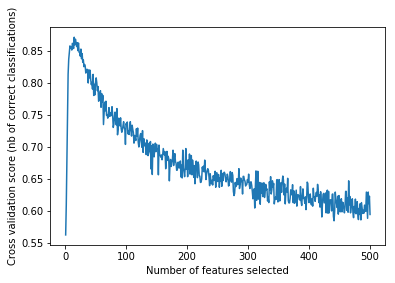

In [16]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe_cv.grid_scores_) + 1), rfe_cv.grid_scores_)
plt.show()

In [17]:
X_train_new.shape

(2000, 15)

#  HyperParameter Tuning 

## Logistic Regression Tuning

In [18]:
# Tuning Logistic Regression after feature engineering
# Create regularization hyperparameter space
C = np.logspace(0.00001, 4, 10)
hyperparameters = dict(C=C)
clf_logreg = GridSearchCV(logreg,hyperparameters,cv=10)
best_model_rfe = clf_logreg.fit(X_train_new,ytrain)

print('Best Penalty:', best_model_rfe.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_rfe.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0000230261160268


In [19]:
logreg_tuned = best_model_rfe.score(X_test_new,ytest)
print(logreg_tuned)

0.5933333333333334


#### Trials done before reaching the above conclusion

In [21]:
# Tuning Logistic Regression
# Create regularization hyperparameter space
C = np.logspace(0.001, 4, 10)
hyperparameters = dict(C=C)
clf1 = GridSearchCV(logreg,hyperparameters,cv=5,verbose = 0)
best_model= clf1.fit(Xtrain,ytrain)


In [22]:
print(best_model.score(Xtest,ytest))

0.59


## Random Forest Tuning

In [31]:
param_grid = {'n_estimators': [300,400, 500,600,700,800,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    ###'max_depth' : [4,5,6,7,8], 71.666
    'criterion' :['gini', 'entropy']
}


rf = RandomForestClassifier(random_state=20)
grid_search_rfe = GridSearchCV(estimator = rf,param_grid = param_grid,cv = 3, verbose = 2)
grid_search_rfe.fit(X_train_new,ytrain)
grid_search_rfe.best_params_

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] criterion=gini, max_features=auto, n_estimators=300 .............
[CV]  criterion=gini, max_features=auto, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_features=auto, n_estimators=300 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=gini, max_features=auto, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_features=auto, n_estimators=300 .............
[CV]  criterion=gini, max_features=auto, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_features=auto, n_estimators=400 .............
[CV]  criterion=gini, max_features=auto, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_features=auto, n_estimators=400 .............
[CV]  criterion=gini, max_features=auto, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_features=auto, n_estimators=400 .............
[CV]  criterion=gini, max_features=auto, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_features=auto, n_estimators=500 .............
[CV]  criterion=gini, max_features=auto, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_features=auto, n_estimators=500 .............
[CV]  criterion=gini, max_features=auto, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_features=auto, n_estimators=500 ......

[CV]  criterion=gini, max_features=log2, n_estimators=800, total=   2.4s
[CV] criterion=gini, max_features=log2, n_estimators=800 .............
[CV]  criterion=gini, max_features=log2, n_estimators=800, total=   2.4s
[CV] criterion=gini, max_features=log2, n_estimators=1000 ............
[CV]  criterion=gini, max_features=log2, n_estimators=1000, total=   3.0s
[CV] criterion=gini, max_features=log2, n_estimators=1000 ............
[CV]  criterion=gini, max_features=log2, n_estimators=1000, total=   3.0s
[CV] criterion=gini, max_features=log2, n_estimators=1000 ............
[CV]  criterion=gini, max_features=log2, n_estimators=1000, total=   3.0s
[CV] criterion=entropy, max_features=auto, n_estimators=300 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=300, total=   1.4s
[CV] criterion=entropy, max_features=auto, n_estimators=300 ..........
[CV]  criterion=entropy, max_features=auto, n_estimators=300, total=   1.4s
[CV] criterion=entropy, max_features=auto, n_estimator

[CV]  criterion=entropy, max_features=log2, n_estimators=600, total=   2.7s
[CV] criterion=entropy, max_features=log2, n_estimators=600 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=600, total=   2.8s
[CV] criterion=entropy, max_features=log2, n_estimators=600 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=600, total=   2.7s
[CV] criterion=entropy, max_features=log2, n_estimators=700 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=700, total=   3.2s
[CV] criterion=entropy, max_features=log2, n_estimators=700 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=700, total=   3.3s
[CV] criterion=entropy, max_features=log2, n_estimators=700 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=700, total=   3.2s
[CV] criterion=entropy, max_features=log2, n_estimators=800 ..........
[CV]  criterion=entropy, max_features=log2, n_estimators=800, total=   3.7s
[CV] criterion=entropy, max_features=log2,

[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  5.3min finished


{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 600}

In [32]:

randomforest_tuned = grid_search_rfe.score(X_test_new,ytest)
print(randomforest_tuned)

0.89


#### Trails done before reaching the above result

In [26]:
forest = RandomForestClassifier(random_state = 20)

rfe = RFE(forest,10)
fit = rfe.fit(Xtrain,ytrain)
X_train_new = fit.transform(Xtrain)
X_test_new = fit.transform(Xtest)
forest.fit(X_train_new,ytrain)
print(forest.score(X_test_new,ytest))


0.8616666666666667


## Gradient Boosting Tuning

In [27]:
parameters = {
    #"loss":["deviance"],
    "learning_rate": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[10,20,30,40],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #"n_estimators":[100,200,300,400,500]
   }
best_learningrate = 0
score = 0
learning_rate = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 
for i in learning_rate:
    #print("Learning rate",i)
    
    clf = GradientBoostingClassifier(n_estimators=20, learning_rate = i, max_features= 4, max_depth = 20, random_state = 40)

    clf.fit(X_train_new,ytrain)
    
    if clf.score(X_test_new,ytest) > score:
        score = clf.score(X_test_new,ytest)
        best_learningrate = i


In [28]:
print(best_learningrate)

0.1


In [29]:
clf = GradientBoostingClassifier(n_estimators=20,learning_rate= best_learningrate,max_features = 4,max_depth =20,random_state = 40)
clf.fit(X_train_new,ytrain)
gradientboosting_tune = clf.score(X_test_new,ytest)

In [27]:
print(gradientboosting_tune)

0.8916666666666667


#### Trails done before reaching the above result

In [30]:
parameters = {
    #"loss":["deviance"],
    "learning_rate": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    #"max_depth":[10,20,30,40],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #"n_estimators":[100,200,300,400,500]
   }
best_learningrate = 0
score = 0
learning_rate = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 
for i in learning_rate:
    print("Learning rate",i)
    
    clf_old = GradientBoostingClassifier(n_estimators=20, learning_rate = i, max_features=200, max_depth = 20, random_state = 40)

    clf_old.fit(Xtrain,ytrain)
    #if clf.score(Xtest,ytest) > score:
    #   score = clf.score(y.iloc[:,:493],y.iloc[:,493])
        
    #   best_learningrate = i
    print(clf_old.score(Xtest,ytest))


Learning rate 0.1
0.855
Learning rate 0.2
0.865
Learning rate 0.3
0.8533333333333334
Learning rate 0.4
0.8566666666666667
Learning rate 0.5
0.86
Learning rate 0.6
0.8466666666666667
Learning rate 0.7
0.8616666666666667
Learning rate 0.8
0.8583333333333333
Learning rate 0.9
0.8233333333333334
Learning rate 1
0.8266666666666667


In [33]:
d = {'BaseModels Accuracy' : pd.Series([logreg_base,randomforest_base, gradientboosting_base], index=['Logistic Regression', 'Random Forest', 'Gradient Boosting']),
   'Tuned Models Accuracy' : pd.Series([logreg_tuned,randomforest_tuned, gradientboosting_tune], index=['Logistic Regression','Random Forest','Gradient Boosting'])}

In [34]:
df = pd.DataFrame(d)
df

,BaseModels Accuracy,Tuned Models Accuracy
Logistic Regression,0.591667,0.593333
Random Forest,0.628333,0.890000
Gradient Boosting,0.748333,0.895000


### Ensembling models [Linear Regression, RandomForest,Gradient Boosting] using voting classifier

In [36]:
eclf = VotingClassifier(estimators=[('lr', best_model_rfe), ('rf', fit), ('gbc', clf)], voting='hard')
eclf.fit(X_train_new,ytrain)
eclf.score(X_test_new,ytest)

/home/agastya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.89